#Installing and Importing Packages

In [1]:
!pip install dwave.system
!pip install dwave.cloud
!pip install dwave.samplers

ERROR: Could not find a version that satisfies the requirement dwave.cloud (from versions: none)
ERROR: No matching distribution found for dwave.cloud


In [2]:
import numpy as np
from collections import defaultdict
from dimod import SimulatedAnnealingSampler
import random
import time
import networkx as nx
import matplotlib.pyplot as plt
from bokeh.palettes import Spectral

# Постановка задачи
Есть n предметов и рюкзак, вместимоси capacity. У каждого есть вес и стоимость. Наша задача - максимизировать стоимость предметов, при этом не превосходя capacity.

#Brute Force - полный перебор решений
Асимптотика O(2^N), где N - число предметов

In [3]:
items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
values_list = [8, 47, 10, 5, 16]

items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
weights_list = [3, 11, 14, 19, 5]

maximum_weight = 26

items_values = {"⚽️": 10, "💻": 10, "📸": 10, "📚": 10, "🎸": 10}

In [4]:
def sum_weight(bitstring, items_weight):
    weight = 0
    for n, i in enumerate(items_weight):
        if bitstring[n] == "1":
            weight += i
    return weight


def sum_values(bitstring, items_value):
    value = 0
    for n, i in enumerate(items_value):
        if bitstring[n] == "1":
            value += i
    return value

items = list(items_values.keys())
n_items = len(items)
combinations = {}
max_value = 0
for case_i in range(2**n_items):  # all possible options
    combinations[case_i] = {}
    bitstring = np.binary_repr(
        case_i, n_items
    )  # bitstring representation of a possible combination, e.g, "01100" in our problem means bringing (-💻📸--)
    combinations[case_i]["items"] = [items[n] for n, i in enumerate(bitstring) if i == "1"]
    combinations[case_i]["value"] = sum_values(bitstring, values_list)
    combinations[case_i]["weight"] = sum_values(bitstring, weights_list)
    # save the information of the optimal solution (the one that maximizes the value while respecting the maximum weight)
    if (
        combinations[case_i]["value"] > max_value
        and combinations[case_i]["weight"] <= maximum_weight
    ):
        max_value = combinations[case_i]["value"]
        optimal_solution = {
            "items": combinations[case_i]["items"],
            "value": combinations[case_i]["value"],
            "weight": combinations[case_i]["weight"],
        }


print(
    f"The best combination is {optimal_solution['items']} with a total value: {optimal_solution['value']} and total weight {optimal_solution['weight']} "
)

The best combination is ['⚽️', '💻', '🎸'] with a total value: 71 and total weight 19 


# DP Soluton
решение, использующее динамическое программирование.

Асимптотика O(СN), где С - capacity, N - количество предметов

(все веса действительные неотрицательные)

In [5]:
def dp_solution(costs, weights, capacity):
    num_of_items = len(weights)
    dp = [[0 for x in range(capacity + 1)] for x in range(num_of_items + 1)]

    for i in range(num_of_items + 1):
        for weight in range(capacity + 1):
            if i == 0 or weight == 0:
                dp[i][weight] = 0
            elif weights[i - 1] <= weight:
                dp[i][weight] = max(costs[i-1]
                            + dp[i - 1][weight - weights[i-1]],
                            dp[i - 1][weight])
            else:
                dp[i][weight] = dp[i - 1][weight]

    cur_item = num_of_items
    cur_weight = capacity
    used_items = [0 for i in range(num_of_items)]
    while (cur_item != 0 and cur_weight != 0):
        if (dp[cur_item - 1][cur_weight] == dp[cur_item][cur_weight]):
            cur_item -= 1;
        else:
            cur_weight -= weights[cur_item - 1]
            used_items[cur_item - 1] = 1;
            cur_item -= 1;

    return used_items

#QUBO Solution
Решение, использующее матрицу QUBO

In [6]:
def make_qubo(costs, weights, max_weight):
    q = defaultdict(int)
    hyper_parameter = 2

    for i in range(len(weights)):
        if i < len(costs):
            q[(i, i)] += hyper_parameter * weights[i] * (weights[i] - 2 * max_weight) - costs[i]
        else:
            q[(i, i)] += hyper_parameter * weights[i] * (weights[i] - 2 * max_weight)
        for j in range(i + 1, len(weights)):
            q[(i, j)] += 2 * hyper_parameter * weights[i] * weights[j]

    # lambd = 2
    # for i in range(len(weights)):
    #     q[(i, i)] += lambd * weights[i] * (weights[i] - 2 * maximum_weight)  # Eq. 10
    #     for j in range(i + 1, len(weights)):
    #         q[(i, j)] += 2 * lambd * weights[i] * weights[j]
    return q

def qubo_solution(costs, weights, max_weight):
    q = make_qubo(costs, weights, max_weight)

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(q)

    ans = sampleset.first.sample
    ans_array = [ans[i] for i in range(len(costs))]
    ans_weight = sum([ans_array[i] * weights[i] for i in range(len(costs))])
    ans_cost = sum([ans_array[i] * costs[i] for i in range(len(costs))])

    return ans_array

# Utils

In [7]:
def timer(ret=False):
    def wrapper(func):
        def wrapped(*args):
            start_time = time.perf_counter_ns()
            res = func(*args)
            ms = (time.perf_counter_ns() - start_time) * 1e-6

            if ret:
                return res, ms
            print(ms, "ms")

            return res

        return wrapped

    return wrapper

In [8]:
def get_result(costs, weights, used_items):
    used_weight = sum([weights[i] * used_items[i] for i in range(len(weights))])
    cost = sum([costs[i] * used_items[i] for i in range(len(weights))])
    return used_weight, cost

# Тесты

In [9]:
"""
Пример теста:
8 47 10 5 16
3 11 14 19 5
26
"""

costs = list(map(int, input().split()))
weights = list(map(int, input().split()))
capacity = int(input())

8 47 10 5 16
3 11 14 19 5
26


In [10]:
bin_ans, time_ = timer(True)(qubo_solution)(costs, weights, capacity)

In [11]:
print(bin_ans)
time_

[1, 1, 1, 0, 0]


672.797389

In [12]:
get_result(costs, weights, bin_ans)

(28, 65)

In [13]:
bin_ans, time_ = timer(True)(dp_solution)(costs, weights, capacity)

In [14]:
print(bin_ans)
time_

[1, 1, 0, 0, 1]


0.12931299999999998

In [15]:
get_result(costs, weights, bin_ans)

(19, 71)

In [43]:
dp_answers = []
qubo_answers = []
def tests():
    for num_of_items in range(1, 10):
        num_of_tests = 1
        qubo_time = 0
        dp_time = 0

        num_cap = 1000000
        for test in range(num_of_tests):
            costs = [random.randint(1, num_cap) for i in range(num_of_items)]
            weights = [random.randint(1, num_cap) for i in range(num_of_items)]
            capacity = random.randint(1, 3 * num_cap)
            dp_ans, time_ = timer(True)(dp_solution)(weights, costs, capacity)
            dp_time += time_

            dp_answers.append([[get_result(costs, weights, dp_ans)], time_]);

            qubo_ans, time_ = timer(True)(qubo_solution)(costs, weights, capacity)
            qubo_time += time_

            qubo_answers.append([[get_result(costs, weights, qubo_ans)], time_]);

    return dp_answers, qubo_answers
        # accuracy /= num_of_tests
        # print(num_of_items, accuracy, "qubo_time = ", qubo_time, "dp_time = ", dp_time)

In [44]:
tests()

([[[(0, 0)], 121.528016],
  [[(717753, 1065093)], 3597.710287],
  [[(1633953, 704919)], 1462.560804],
  [[(1704123, 1807585)], 6037.18732],
  [[(2686512, 1719373)], 5953.007908],
  [[(3109679, 2169939)], 9218.93875],
  [[(3091750, 1137503)], 5517.481562999999],
  [[(690245, 143651)], 1777.837024],
  [[(1699438, 1167157)], 6964.897540999999]],
 [[[(440341, 868240)], 23.57473],
  [[(717753, 1065093)], 51.166523],
  [[(964115, 85056)], 99.06693399999999],
  [[(1704123, 1807585)], 138.121647],
  [[(1990009, 1147945)], 208.500655],
  [[(2308762, 1631467)], 299.776322],
  [[(1218186, 184693)], 3166.2257919999997],
  [[(600336, 860312)], 452.267091],
  [[(1449881, 1516632)], 1107.268024]])

In [45]:
for i in range(len(dp_answers)):
    print(dp_answers[i])
    print(qubo_answers[i])

[[(0, 0)], 121.528016]
[[(440341, 868240)], 23.57473]
[[(717753, 1065093)], 3597.710287]
[[(717753, 1065093)], 51.166523]
[[(1633953, 704919)], 1462.560804]
[[(964115, 85056)], 99.06693399999999]
[[(1704123, 1807585)], 6037.18732]
[[(1704123, 1807585)], 138.121647]
[[(2686512, 1719373)], 5953.007908]
[[(1990009, 1147945)], 208.500655]
[[(3109679, 2169939)], 9218.93875]
[[(2308762, 1631467)], 299.776322]
[[(3091750, 1137503)], 5517.481562999999]
[[(1218186, 184693)], 3166.2257919999997]
[[(690245, 143651)], 1777.837024]
[[(600336, 860312)], 452.267091]
[[(1699438, 1167157)], 6964.897540999999]
[[(1449881, 1516632)], 1107.268024]


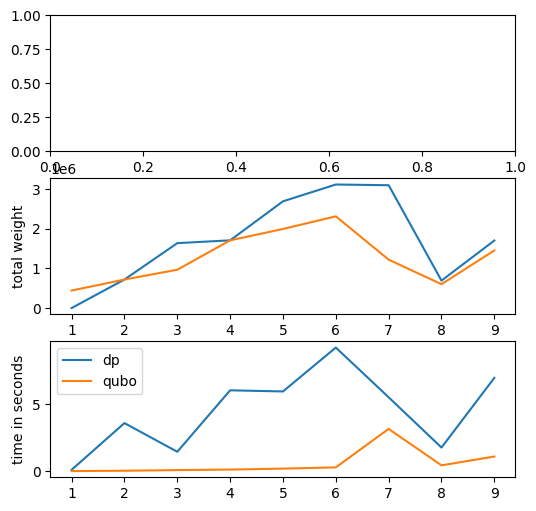

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

num_of_items = [i for i in range(1, len(dp_answers) + 1)]

#weights
dp_weights = [dp_answers[i][0][0][0] for i in range(len(dp_answers))]
qubo_weights = [qubo_answers[i][0][0][0] for i in range(len(qubo_answers))]

ax2.plot(num_of_items, dp_weights, label="dp")
ax2.plot(num_of_items, qubo_weights, label="qubo")
ax2.set_ylabel("total weight")

#time
dp_time = [dp_answers[i][1] / 1000 for i in range(len(dp_answers))]
qubo_time = [qubo_answers[i][1] / 1000 for i in range(len(qubo_answers))]

ax3.plot(num_of_items, dp_time, label="dp")
ax3.plot(num_of_items, qubo_time, label="qubo")
ax3.set_ylabel("time in seconds")

plt.legend()
plt.show()
